In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

## Dataset loading

### Regular dataset loading

In [2]:
from python_proj.utils.util import Counter
import python_proj.utils.exp_utils as exp_utils

# Defines a number of constants.

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_full/"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()

In [3]:
import pandas as pd
import numpy as np
import json


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]

df.describe()

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,1.473092e+08,5.092504e+06,8.089130e+02,5.029367e-01,4.028501e-01,9.853429e-02,3.751776e-01,5.922709e-02,4.195426e-01,1.183858e-01,...,1.144450e-02,1.968795e-02,7.962418e-02,1.344287e-01,9.542167e-03,1.752697e-02,6.396780e-02,6.040052e-02,2.195312e-02,4.472791e-02
std,9.954409e+07,7.968202e+06,2.304617e+03,4.710606e-01,4.523397e-01,2.907111e-01,4.479337e-01,2.285036e-01,2.256901e-01,7.147764e-02,...,5.396848e-02,8.007560e-02,1.179799e-01,1.750052e-01,5.263118e-02,8.245257e-02,9.934566e-02,1.002992e-01,8.741610e-02,1.013945e-01
min,6.870000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.924867e+07,4.674710e+05,5.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.365158e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.366714e+08,1.633887e+06,1.990000e+02,6.800000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.433349e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,8.453635e-03,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.260994e+08,6.254382e+06,6.840000e+02,1.000000e+00,9.391304e-01,0.000000e+00,9.230769e-01,0.000000e+00,5.863557e-01,1.505134e-01,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,9.892883e-02,8.837267e-02,0.000000e+00,2.582313e-02
max,3.617756e+08,5.973444e+07,8.297600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
print(list(df.columns))

['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At', 'PullRequestIsMerged', 'ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystem

In [5]:
# Identifieds independent / predictor fields.


def is_independent_field(field: str) -> bool:
    return field not in metadata_fields and field != pr_merged_key


independent_fields = list(filter(is_independent_field, df.columns))

In [6]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

class_imbalance=3.6991542286634957


## Model Creation

In [7]:
k = 5
print(f"Using {k=} folds.")

Using k=5 folds.


Generates a number of feature groups that are relevant later in the pipeline:
- control variables
- intra-project experience
- ecosystem experience
- dependency ecosystem experience
- inverse dependency ecosystem experience
- non-dependency ecosystem experience
- collaboration variables

In [8]:
from enum import Enum
from python_proj.utils.util import get_matching

# Defines feature groups


class FeatureGroups(Enum):
    Control = 1
    Intra = 2
    Eco = 3
    DEco = 4
    IDEco = 5
    NDEco = 6
    Coll = 7


var_group_regex_patterns = [
    (FeatureGroups.Control, r".*Control.*"),
    (
        FeatureGroups.Intra,
        r"^(?:(?!Control|Degree|Link).)*Intra(?:(?!Control|Degree|Link).)*$",
    ),
    (FeatureGroups.Eco, r"^(?:(?!Dependency).)*Ecosystem(?:(?!Degree|Link).)*$"),
    (FeatureGroups.DEco, r"^(?!.*(Inverse|Non)).*(?=Dependency).*"),
    (FeatureGroups.IDEco, r".*(?=Inverse).*"),
    (FeatureGroups.NDEco, r".*(?=NonDependency).*"),
    (FeatureGroups.Coll, r"^(?:(?!Intra).)*(Weighted|LinkIntensity)(?:(?!Intra).)*$"),
]

# Resolves the regex patterns to generate lists of fields.
var_groups = {
    str(name): list(get_matching(independent_fields, pattern))
    for name, pattern in var_group_regex_patterns
}


print("Feature groups:")
print(json.dumps(var_groups, indent=2))

Feature groups:
{
  "FeatureGroups.Control": [
    "ControlIntegratedBySameUser",
    "ControlPullRequestHasComments",
    "ControlPullRequestHasCommentByExternalUser",
    "ControlHasHashTagInDescription",
    "ln(1 + ControlPullRequestLifeTimeInMinutes)",
    "ln(1 + ControlNumberOfCommitsInPullRequest)",
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)"
  ],
  "FeatureGroups.Intra": [
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)"
  ],
  "FeatureGroups.Eco": [
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + Ecosyst

In [9]:
from wmeijer_utils.collections.list_access import flatten


def get_feature_groups(*feature_groups) -> list[str]:
    return list(flatten(var_groups[str(group)] for group in feature_groups))

### Full Model

In [10]:
from python_proj.modelling.notebooks.random_forest.rf_functions import (
    kfold_rf_evaluation,
)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics full model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

random_state=43
random_state=43
random_state=43random_state=43

random_state=43
metrics={'accuracy': 0.8734650249748196, 'precision': 0.8971733159444346, 'recall': 0.9479895812127761, 'f1': 0.9218817020088578}

Confusion matrix:
[[ 30853  20815]
 [  9964 181613]]

Classification report:
              precision    recall  f1-score   support

       False       0.76      0.60      0.67     51668
        True       0.90      0.95      0.92    191577

    accuracy                           0.87    243245
   macro avg       0.83      0.77      0.79    243245
weighted avg       0.87      0.87      0.87    243245

metrics={'accuracy': 0.8740400585420401, 'precision': 0.8974063770808525, 'recall': 0.9484265825561115, 'f1': 0.9222113614725486}

Confusion matrix:
[[ 30987  20763]
 [  9876 181618]]

Classification report:
              precision    recall  f1-score   support

       False       0.76      0.60      0.67     51750
        True       0.90      0.95      0.92    191494

    accuracy 

### Control + Intra-project Model

In [11]:
contr_with_intra = get_feature_groups(FeatureGroups.Control, FeatureGroups.Intra)
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, contr_with_intra, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics control + intra model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

(<FeatureGroups.Control: 1>, <FeatureGroups.Intra: 2>)
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']


random_state=45
random_state=45
random_state=45
random_state=45
random_state=45
metrics={'accuracy': 0.8552077123887438, 'precision': 0.8908728274290056, 'recall': 0.9301233240609783, 'f1': 0.9100750651074913}

Confusion matrix:
[[ 29805  21831]
 [ 13389 178220]]

Classification report:
              precision    recall  f1-score   support

       False       0.69      0.58      0.63     51636
        True       0.89      0.93      0.91    191609

    accuracy                           0.86    243245
   macro avg       0.79      0.75      0.77    243245
weighted avg       0.85      0.86      0.85    243245

metrics={'accuracy': 0.8545000082221966, 'precision': 0.8896731203420648, 'recall': 0.9304909776714347, 'f1': 0.9096243711856183}

Confusion matrix:
[[ 29743  22087]
 [ 13305 178109]]

Classification report:
              precision    recall  f1-score   support

       False       0.69      0.57      0.63     51830
        True       0.89      0.93      0.91    191414

    accuracy 

### Collaboration and Ecosystem Model

In [12]:
non_control_intra_fields = get_feature_groups(
    FeatureGroups.Eco,
    FeatureGroups.DEco,
    FeatureGroups.IDEco,
    FeatureGroups.NDEco,
    FeatureGroups.Coll,
)
print(non_control_intra_fields)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, non_control_intra_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics non-control model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

(<FeatureGroups.Eco: 3>, <FeatureGroups.DEco: 4>, <FeatureGroups.IDEco: 5>, <FeatureGroups.NDEco: 6>, <FeatureGroups.Coll: 7>)
['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestC

random_state=47
random_state=47
random_state=47
random_state=47
random_state=47
metrics={'accuracy': 0.7801352545787169, 'precision': 0.7962613933479592, 'recall': 0.9685313224573351, 'f1': 0.8739883085579376}

Confusion matrix:
[[  4298  47455]
 [  6026 185466]]

Classification report:
              precision    recall  f1-score   support

       False       0.42      0.08      0.14     51753
        True       0.80      0.97      0.87    191492

    accuracy                           0.78    243245
   macro avg       0.61      0.53      0.51    243245
weighted avg       0.72      0.78      0.72    243245

metrics={'accuracy': 0.7823954547696963, 'precision': 0.7979528336301797, 'recall': 0.9694806549170925, 'f1': 0.8753934343256001}

Confusion matrix:
[[  4386  47078]
 [  5853 185927]]

Classification report:
              precision    recall  f1-score   support

       False       0.43      0.09      0.14     51464
        True       0.80      0.97      0.88    191780

    accuracy 

## Feature Explanation and Evaluation

### Model Creation

In [13]:
from sklearn.model_selection import train_test_split

from python_proj.modelling.notebooks.random_forest.rf_functions import create_model


train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]


full_rf_model, _ = create_model(
    train_predictors, train_dependent, test_predictors, test_dependent, seed_counter
)

random_state=49
metrics={'accuracy': 0.8739377993381159, 'precision': 0.8980581322213362, 'recall': 0.9473395501919912, 'f1': 0.9220408101003219}

Confusion matrix:
[[ 31246  20584]
 [ 10080 181335]]

Classification report:
              precision    recall  f1-score   support

       False       0.76      0.60      0.67     51830
        True       0.90      0.95      0.92    191415

    accuracy                           0.87    243245
   macro avg       0.83      0.78      0.80    243245
weighted avg       0.87      0.87      0.87    243245



### Mean decrease in Impurity

/tmp/ipykernel_832/1648129876.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


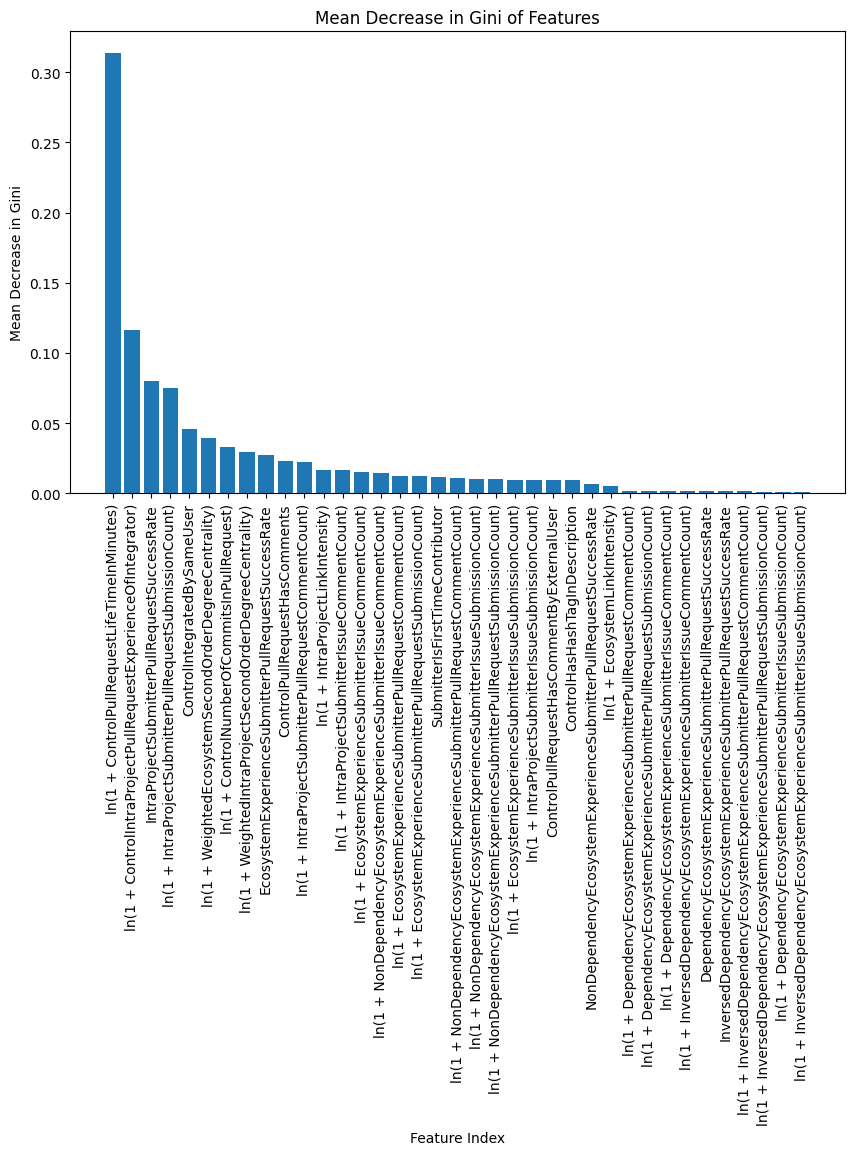

In [14]:
from matplotlib import pyplot as plt

feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel("Feature Index")
plt.ylabel("Mean Decrease in Gini")
plt.title("Mean Decrease in Gini of Features")
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

In [15]:
# Stores feature importances in file.
output_file = f"{figure_base_path}/feature_importance.txt"
with open(output_file, "w+", encoding="utf-8") as output_file:
    for field, importance in zip(ordererd_columns, sorted_importances):
        entry = f"{field}: {importance}"
        output_file.write(f'{entry}\n')
        print(entry)

ln(1 + ControlPullRequestLifeTimeInMinutes): 0.3133861057269014
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.11601044612634273
IntraProjectSubmitterPullRequestSuccessRate: 0.0801505992663936
ln(1 + IntraProjectSubmitterPullRequestSubmissionCount): 0.07473859271988464
ControlIntegratedBySameUser: 0.045583002539410354
ln(1 + WeightedEcosystemSecondOrderDegreeCentrality): 0.039600622806487885
ln(1 + ControlNumberOfCommitsInPullRequest): 0.0332415707544939
ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality): 0.029626943171615457
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.02744770576376318
ControlPullRequestHasComments: 0.02310786518882984
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.022173318409257983
ln(1 + IntraProjectLinkIntensity): 0.016855664645856895
ln(1 + IntraProjectSubmitterIssueCommentCount): 0.016748691327011067
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.015202752962766228
ln(1 + NonDependencyEcosystemExperienceSubmitte

### Variable Group Reverse Ablation Studies

Creates a model with a subset of features.
Compared to regular ablation, it tests "what happens if I add a feature", instead of "what happens when I remove one".

In [16]:
rev_abl_results = dict()

for cluster_name, cluster in var_groups.items():
    print(f'Reverse ablation with "{str(cluster_name)}", including: {cluster}.')

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, cluster, k, pr_merged_key, seed_counter
    )
    rev_abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

Reverse ablation with "FeatureGroups.Control", including: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].


random_state=50
random_state=50
random_state=50
random_state=50
random_state=50
metrics={'accuracy': 0.7995642253694835, 'precision': 0.8517131568083978, 'recall': 0.9031689865600784, 'f1': 0.8766866898514071}

Confusion matrix:
[[ 21180  30174]
 [ 18581 173310]]

Classification report:
              precision    recall  f1-score   support

       False       0.53      0.41      0.46     51354
        True       0.85      0.90      0.88    191891

    accuracy                           0.80    243245
   macro avg       0.69      0.66      0.67    243245
weighted avg       0.78      0.80      0.79    243245

metrics={'accuracy': 0.7988891812336584, 'precision': 0.8499997543637283, 'recall': 0.9039424051492638, 'f1': 0.8761415741887133}

Confusion matrix:
[[ 21305  30533]
 [ 18386 173020]]

Classification report:
metrics={'accuracy': 0.8008255085428623, 'precision': 0.8507312721783284, 'recall': 0.9060741467692597, 'f1': 0.8775310040091608}

Confusion matrix:
[[ 21223  30455]
 [ 17993 17

In [17]:
# Prints summarized results again for clarity.
print("Reverse cluster ablation results:")
for cluster_name, (f1_scores, f1_mean, f1_std) in rev_abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Reverse cluster ablation results:
Cluster 'FeatureGroups.Control':
f1_scores=[0.8766866898514071, 0.8761415741887133, 0.8775310040091608, 0.8761976566789205, 0.8753945055446076]
f1_mean=0.8763902860545618, f1_std=0.0007042208680957024

Cluster 'FeatureGroups.Intra':
f1_scores=[0.8805661880291271, 0.8816304133719786, 0.88105987366366, 0.8808240552811571, 0.8811807114194381]
f1_mean=0.8810522483530722, f1_std=0.0003575366863560466

Cluster 'FeatureGroups.Eco':
f1_scores=[0.8762571952315902, 0.876163932053679, 0.8759321432407066, 0.8767430790195823, 0.8774435827161933]
f1_mean=0.8765079864523502, f1_std=0.0005373032577858074

Cluster 'FeatureGroups.DEco':
f1_scores=[0.8803728542564686, 0.8809258457599175, 0.8811287656600351, 0.8802009170295615, 0.8797744806300897]
f1_mean=0.8804805726672145, f1_std=0.0004912837834903154

Cluster 'FeatureGroups.IDEco':
f1_scores=[0.8797603134362756, 0.8798242803769768, 0.8805286396373778, 0.8805567966688008, 0.8817292869797299]
f1_mean=0.8804798634198322, 

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [18]:
import random

from python_proj.modelling.notebooks.random_forest.rf_functions import calculate_metrics

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=}.")
print(json.dumps(metrics, indent=4))

Probability guesser metrics with probability_true=0.7871957481411684.
{
    "accuracy": 0.6660404119303582,
    "precision": 0.7871225979955282,
    "recall": 0.7889977274508267,
    "f1": 0.7880590472910567
}


In [19]:
import datetime

print(datetime.datetime.now())

2024-02-20 15:37:42.362564
